# Imports

In [39]:
from datetime import datetime
import math, hashlib, json, os

import pandas as pd, numpy as np,matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, levene, chi2_contingency, spearmanr, norm

from collections import Counter
from pathlib import Path

# Directory Structuring

In [2]:
os.makedirs('../outputs', exist_ok=True)

cleaned_dataset_path = '../outputs/cleaned_data.csv'
eda_describe_path = '../outputs/descriptive_summary.csv' 

if os.path.exists(eda_describe_path):
    eda_describe = pd.read_csv(eda_describe_path, index_col=0)
    print("Loaded eda_describe:", eda_describe.shape)
else:
    eda_describe = None
    print("No eda_describe found at", eda_describe_path)

Loaded eda_describe: (80, 11)


# Loading Data-set

In [3]:
try:
    df
    print("Using in-memory df with shape", df.shape)
except NameError:
    try:
        df = pd.read_csv(cleaned_dataset_path)
        print(f"Loaded df from {cleaned_dataset_path} shape", df.shape)
    except Exception as e:
        raise RuntimeError("Cleaned dataframe `df` not in memory and default path not found. Load your cleaned df into variable `df` before proceeding.") from e

df

Loaded df from ../outputs/cleaned_data.csv shape (2522362, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack_Binary
0,54865,3.0,2,0,12,0,6,6,6.0,0.00000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
1,55054,109.0,1,1,6,6,6,6,6.0,0.00000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
2,55055,52.0,1,1,6,6,6,6,6.0,0.00000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
3,46236,34.0,1,1,6,6,6,6,6.0,0.00000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
4,54863,3.0,2,0,12,0,6,6,6.0,0.00000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522357,53,32215.0,4,2,112,152,28,28,28.0,0.00000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
2522358,53,324.0,2,2,84,362,42,42,42.0,0.00000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
2522359,58030,82.0,2,1,31,6,31,0,15.5,21.92031,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
2522360,53,1048635.0,6,2,192,256,32,32,32.0,0.00000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN


# Adding the Protocol Column

In [4]:
def looks_like_protocol_series(s, check_n=500):
    # sample values and check for TCP/UDP/ICMP keywords
    sample = s.dropna().astype(str).str.upper().head(check_n).tolist()
    kw = {'TCP','UDP','ICMP'}
    found = any(any(k in v for k in kw) for v in sample)
    unique_count = len(pd.unique(sample))
    return found, unique_count, sample[:10]

In [5]:
protocol_candidates = []
for c in df.columns:
    if df[c].dtype == object or df[c].dtype == 'O':
        found, uniq, samp = looks_like_protocol_series(df[c])
        if found:
            protocol_candidates.append((c, uniq, samp))

C:\Users\Yash Verma\AppData\Local\Temp\ipykernel_3556\336264030.py:6: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_count = len(pd.unique(sample))
C:\Users\Yash Verma\AppData\Local\Temp\ipykernel_3556\336264030.py:6: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_count = len(pd.unique(sample))


In [6]:
port_candidates = []
for c in df.columns:
    if 'PORT' in c.upper() or 'DPORT' in c.upper() or 'DEST' in c.upper():
        if pd.api.types.is_integer_dtype(df[c]) or pd.api.types.is_float_dtype(df[c]):
            port_candidates.append(c)

In [7]:
# create a simple mapping of common ports -> protocol-like labels
def port_to_proto(p):
    try:
        p = int(p)
    except:
        return 'UNKNOWN'

    # ICMP has no port; we can't detect it via ports. We'll just mark as TCP/UDP/OTHER by well-known ports.
    TCP_HTTP_FTP_SSH_ports = (80, 443, 8080, 20, 21, 22, 23, 25, 110, 143)
    UDP_DNS_ports = (53,67,68)
    if p in TCP_HTTP_FTP_SSH_ports:
        return 'TCP_HTTP_FTP_SSH'
    if p in UDP_DNS_ports:  # DNS
        return 'UDP_DNS'
    if 0 < p < 1024:
        return 'WELL_KNOWN_PORT'
    if p >= 1024:
        return 'EPHEMERAL'
    return 'OTHER'

In [8]:
protocol_col = None

if len(protocol_candidates) > 0:
    protocol_col = protocol_candidates[0][0]
    print(f"Using detected protocol-like column: {protocol_col}")
else:
    print("No protocol-like textual column found.")
    # fallback: if we have Destination/Source Port, use it to create protocol proxy
    # choose best port column available
    if len(port_candidates) > 0:
        port_col = port_candidates[0]
        print("Using numeric port column as proxy:", port_col)
        protocol_col = '__Protocol_from_Port__'

        df[protocol_col] = df[port_col].apply(port_to_proto)
        print(f"Created fallback column '{protocol_col}' from port '{port_col}'.")
    else:
        print("No port-like column found. Protocol-based chi-square cannot be executed automatically.")
        protocol_col = None

No protocol-like textual column found.
Using numeric port column as proxy: Destination Port
Created fallback column '__Protocol_from_Port__' from port 'Destination Port'.


In [9]:
# summary

print("Protocol-like object columns found:", protocol_candidates)
print("Potential port columns found (numeric):", port_candidates)

if protocol_col is not None:
    print("Protocol column chosen:", protocol_col)
    print("Protocol value sample:", pd.Series(df[protocol_col].dropna().astype(str)).unique())
else:
    print("Protocol analysis will be skipped; please add a protocol column or choose port column manually.")

Protocol-like object columns found: []
Potential port columns found (numeric): ['Destination Port']
Protocol column chosen: __Protocol_from_Port__
Protocol value sample: ['EPHEMERAL' 'UDP_DNS' 'TCP_HTTP_FTP_SSH' 'WELL_KNOWN_PORT' 'OTHER']


In [10]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack_Binary,__Protocol_from_Port__
0,54865,3.0,2,0,12,0,6,6,6.0,0.00000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,EPHEMERAL
1,55054,109.0,1,1,6,6,6,6,6.0,0.00000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,EPHEMERAL
2,55055,52.0,1,1,6,6,6,6,6.0,0.00000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,EPHEMERAL
3,46236,34.0,1,1,6,6,6,6,6.0,0.00000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,EPHEMERAL
4,54863,3.0,2,0,12,0,6,6,6.0,0.00000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,EPHEMERAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522357,53,32215.0,4,2,112,152,28,28,28.0,0.00000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,UDP_DNS
2522358,53,324.0,2,2,84,362,42,42,42.0,0.00000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,UDP_DNS
2522359,58030,82.0,2,1,31,6,31,0,15.5,21.92031,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,EPHEMERAL
2522360,53,1048635.0,6,2,192,256,32,32,32.0,0.00000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN,UDP_DNS


# Test functions for Hypothesis testing

In [11]:
def safe_mannwhitney(col):
    if col not in df.columns:
        return None, None, 0, 0
    a = df[df['Attack_Binary']=='BENIGN'][col].dropna().astype(float)
    b = df[df['Attack_Binary']=='ATTACK'][col].dropna().astype(float)
    if len(a) < 10 or len(b) < 10:
        return None, None, len(a), len(b)
    stat, p = mannwhitneyu(a, b, alternative='two-sided')
    return stat, p, len(a), len(b)

In [12]:
label_col = 'Label'
def safe_kruskal(col):
    if col not in df.columns or label_col not in df.columns:
        return None, None
    groups = [g[col].dropna().astype(float) for _, g in df.groupby(label_col) if len(g[col].dropna()) >= 30]
    if len(groups) < 2:
        return None, None
    stat, p = kruskal(*groups)
    return stat, p

In [13]:
def safe_chi2_return(df, protocol_col, attack_col='Attack_Binary', min_count=50, collapse_label='OTHER'):
    """
    Compute chi2_contingency robustly and return results as plain values.
    DOES NOT write files or mutate global state.
    Returns:
      None if test cannot be run (insufficient categories), otherwise a dict:
      {
        'chi2': float,
        'p': float,
        'dof': int,
        'min_expected': float,
        'contingency': pandas.DataFrame,
        'expected': numpy.ndarray,
        'notes': list(str)
      }
    """
    if protocol_col not in df.columns:
        return None

    # normalized categories
    cont = pd.crosstab(
        df[protocol_col].fillna('UNKNOWN').astype(str).str.upper(),
        df[attack_col].fillna('UNKNOWN').astype(str).str.upper()
    )

    # drop empty rows/cols
    cont = cont.loc[(cont.sum(axis=1) > 0), (cont.sum(axis=0) > 0)]
    if cont.shape[0] < 2 or cont.shape[1] < 2:
        # ? Contingency table too small after dropping empty rows/cols.
        return None

    # collapse rare rows if required
    if min_count is not None and min_count > 0:
        row_totals = cont.sum(axis=1)
        rare = row_totals[row_totals < min_count].index.tolist()
        if rare:
            # ? Protocol Categories are less than the minimun.
            other_row = cont.loc[rare].sum(axis=0)
            cont = cont.drop(index=rare)
            cont.loc[collapse_label] = other_row

    # re-check
    cont = cont.loc[(cont.sum(axis=1) > 0), (cont.sum(axis=0) > 0)]
    if cont.shape[0] < 2 or cont.shape[1] < 2:
        # ? Insufficient categories after collapsing rare ones
        return None

    # ! Testing
    try:
        chi2_stat, p_val, dof, expected = chi2_contingency(cont)
    except Exception as e:
        # ? Test failed
        return None

    notes = []
    min_expected = float(expected.min())
    if min_expected < 5:
        notes.append(f"Min expected cell <5: {min_expected:.3f}")

    return {
        'chi2': float(chi2_stat),
        'p': float(p_val),
        'dof': int(dof),
        'min_expected': min_expected,
        'contingency': cont,
        'expected': expected,
        'notes': notes
    }


In [14]:
def safe_spearman_return(df, feature, attack_col='_attack_num', min_n=50):
    """
    Compute Spearman correlation between feature and attack numeric label.
    Returns None if feature not present or n < min_n.
    Otherwise returns dict:
      {'spearman_r': float or None, 'p': float or None, 'n': int, 'note': str or None}
    """
    if feature not in df.columns:
        return None
    if attack_col not in df.columns:
        # ensure numeric mapping exists
        if 'Attack_Binary' in df.columns:
            df[attack_col] = df['Attack_Binary'].map({'BENIGN':0, 'ATTACK':1})
        else:
            return None

    valid = df[[feature, attack_col]].dropna()
    n = len(valid)
    if n < min_n:
        return {'spearman_r': None, 'p': None, 'n': n, 'note': 'n_too_small'}

    # handle constant input
    if valid[feature].nunique() <= 1:
        return {'spearman_r': None, 'p': None, 'n': n, 'note': 'constant'}

    r, p = spearmanr(valid[feature], valid[attack_col])
    if np.isnan(r):
        return {'spearman_r': None, 'p': None, 'n': n, 'note': 'nan'}
    return {'spearman_r': float(r), 'p': float(p), 'n': n, 'note': None}


## Running Hypothesis Testing

In [15]:
results=list()

### H1 : Flow Duration (Benign vs Attack)

In [16]:
stat, p, na, nb = safe_mannwhitney('Flow Duration')
results.append(['H1', 'Flow Duration difference', 'Mann-Whitney U', 'Flow Duration', stat, p, na, nb])

### H2: Packets per flow differ between attack types (Kruskal-Wallis)

In [17]:
stat2, p2 = safe_kruskal('Total Fwd Packets')
results.append(['H2', 'Packets per flow by attack type', 'Kruskal-Wallis', 'Total Fwd Packets', stat2, p2, None, None])

### H3: Bytes per second variance differs (Levene)

In [18]:
if 'Flow Bytes/s' in df.columns:
    a = df[df['Attack_Binary']=='BENIGN']['Flow Bytes/s'].dropna().astype(float)
    b = df[df['Attack_Binary']=='ATTACK']['Flow Bytes/s'].dropna().astype(float)
    if len(a) >= 10 and len(b) >= 10:
        stat3, p3 = levene(a, b)
        results.append(['H3', 'Variance in Bytes/s', 'Levene', 'Flow Bytes/s', stat3, p3, len(a), len(b)])
    else:
        results.append(['H3', 'Variance in Bytes/s', 'Levene', 'Flow Bytes/s', None, None, len(a), len(b)])
else:
    results.append(['H3', 'Variance in Bytes/s', 'Levene', 'Flow Bytes/s', None, None, 0, 0])

### H4: Protocol associated with attack likelihood (Chi-square)

In [19]:
protocol_col = '__Protocol_from_Port__'
h4_res = safe_chi2_return(df, protocol_col, attack_col='Attack_Binary', min_count=50, collapse_label='OTHER')
if h4_res is None:
    # test could not be computed or insufficient categories
    results.append(['H4', 'Protocol vs Attack Relation', 'Chi-Square', protocol_col, None, None, None, None])
else:
    # compute nA (BENIGN) and nB (ATTACK) from contingency if present
    cont = h4_res['contingency']
    n_benign = int(cont['BENIGN'].sum()) if 'BENIGN' in cont.columns else None
    n_attack = int(cont['ATTACK'].sum()) if 'ATTACK' in cont.columns else None
    results.append(['H4','Protocol vs Attack Relation','Chi-Square',protocol_col,h4_res['chi2'],h4_res['p'],n_benign,n_attack])


In [20]:
h4_res

{'chi2': 360394.2049374206,
 'p': 0.0,
 'dof': 4,
 'min_expected': 264.5737709337518,
 'contingency': Attack_Binary           ATTACK  BENIGN
 __Protocol_from_Port__                
 EPHEMERAL                76526  468419
 OTHER                        6    1561
 TCP_HTTP_FTP_SSH        335940  700240
 UDP_DNS                    101  876783
 WELL_KNOWN_PORT          13305   49481,
 'expected': array([[9.20090323e+04, 4.52935968e+05],
        [2.64573771e+02, 1.30242623e+03],
        [1.74949617e+05, 8.61230383e+05],
        [1.48053929e+05, 7.28830071e+05],
        [1.06008480e+04, 5.21851520e+04]]),
 'notes': []}

###  H5: Idle Mean / Max comparison between Benign and Attack

In [21]:
H5_results=list()
for col in ['Idle Mean', 'Idle Max']:
    stat, p, nA, nB = safe_mannwhitney(col)
    H5_results.append(['H5', f'{col} difference', 'Mann–Whitney U', col, stat, p, nA, nB])

In [22]:
print(H5_results)

[['H5', 'Idle Mean difference', 'Mann–Whitney U', 'Idle Mean', np.float64(279742226519.0), np.float64(0.0), 2096484, 425878], ['H5', 'Idle Max difference', 'Mann–Whitney U', 'Idle Max', np.float64(279157954208.0), np.float64(0.0), 2096484, 425878]]


##### A bit of reasoning and making sense of the result

In [23]:
df[['Idle Mean', 'Idle Max']].describe()

,Idle Mean,Idle Max
count,2.522362e+06,2.522362e+06
mean,9.331578e+06,9.757716e+06
std,2.484157e+07,2.561067e+07
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.200000e+08,1.200000e+08


In [24]:
df[['Idle Mean', 'Idle Max']].dtypes


Idle Mean    float64
Idle Max       int64
dtype: object

In [25]:
# Check the number of unique values and their range
for col in ['Idle Mean', 'Idle Max']:
    print(f"\n{col} unique non-zero count:", (df[col] != 0).sum())
    print(f"{col} min:", df[col].min())
    print(f"{col} max:", df[col].max())
    print(f"{col} sample non-zero values:", df.loc[df[col] > 0, col].head(10).to_list())



Idle Mean unique non-zero count: 567235
Idle Mean min: 0.0
Idle Mean max: 120000000.0
Idle Mean sample non-zero values: [30900000.0, 7114425.0, 49400000.0, 58100000.0, 5030086.0, 31900000.0, 10000000.0, 9620439.833, 9595812.25, 63000000.0]

Idle Max unique non-zero count: 567235
Idle Max min: 0
Idle Max max: 120000000
Idle Max sample non-zero values: [30900000, 7114425, 58500000, 58200000, 5030086, 58000000, 10000000, 10000000, 10000000, 63000000]


In [26]:
for col in ['Idle Mean', 'Idle Max']:
    benign_nonzero = df.loc[(df['Attack_Binary']=='BENIGN') & (df[col]>0), col]
    attack_nonzero = df.loc[(df['Attack_Binary']=='ATTACK') & (df[col]>0), col]
    
    print(f"\n{col} variability:")
    print("Benign std:", benign_nonzero.std())
    print("Attack std:", attack_nonzero.std())
    print("Benign IQR:", np.percentile(benign_nonzero, 75)-np.percentile(benign_nonzero, 25))
    print("Attack IQR:", np.percentile(attack_nonzero, 75)-np.percentile(attack_nonzero, 25))



Idle Mean variability:
Benign std: 26052983.44217669
Attack std: 34512622.73628835
Benign IQR: 23156481.583
Attack IQR: 51600000.0

Idle Max variability:
Benign std: 27152655.850543812
Attack std: 33255096.433824405
Benign IQR: 32200389.5
Attack IQR: 28100000.0


- Attack IQR ≈ double benign IQR.
- Attack std also greater — meaning broader spread of idle values.

So, attack idle behavior is irregular — some flows pause briefly, others for long.

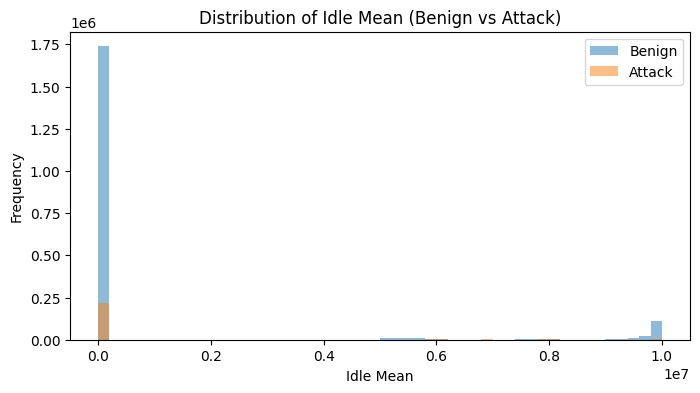

In [27]:
plt.figure(figsize=(8,4))
plt.hist(df.loc[df['Attack_Binary']=='BENIGN', 'Idle Mean'], bins=50, alpha=0.5, label='Benign', range=(0,1e7))
plt.hist(df.loc[df['Attack_Binary']=='ATTACK', 'Idle Mean'], bins=50, alpha=0.5, label='Attack', range=(0,1e7))
plt.xlabel('Idle Mean')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Idle Mean (Benign vs Attack)')
plt.savefig('../outputs/Distribution of Idle Mean (Benign vs Attack).png')
plt.show()

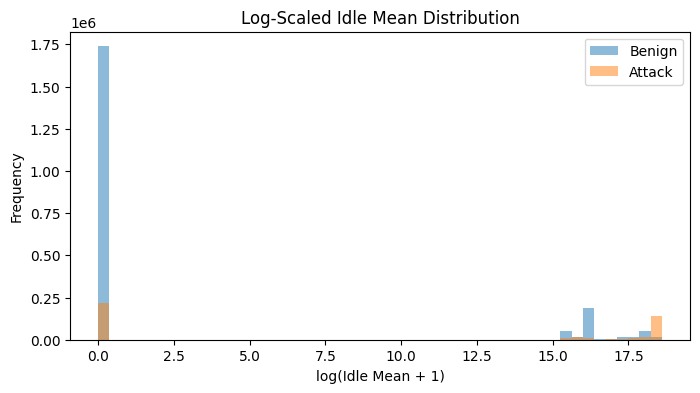

In [28]:
df['Idle Mean log'] = np.log1p(df['Idle Mean'])
plt.figure(figsize=(8,4))
plt.hist(df.loc[df['Attack_Binary']=='BENIGN', 'Idle Mean log'], bins=50, alpha=0.5, label='Benign')
plt.hist(df.loc[df['Attack_Binary']=='ATTACK', 'Idle Mean log'], bins=50, alpha=0.5, label='Attack')
plt.xlabel('log(Idle Mean + 1)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Log-Scaled Idle Mean Distribution')
plt.savefig('../outputs/log_scaled_idle_Mean_distribution.png')
plt.show()


- Doing a Non-zero mann-whitney test

In [29]:
nonzero_df = df[df['Idle Mean'] > 0]
stat, p = mannwhitneyu(
    nonzero_df.loc[nonzero_df['Attack_Binary']=='BENIGN', 'Idle Mean'],
    nonzero_df.loc[nonzero_df['Attack_Binary']=='ATTACK', 'Idle Mean'],
    alternative='two-sided'
)
print("Non-zero Mann–Whitney:", stat, p)


Non-zero Mann–Whitney: 13015208676.0 0.0


In [30]:
zero_counts = df.groupby('Attack_Binary')[['Idle Mean', 'Idle Max']].apply(lambda x: (x==0).sum())
nonzero_counts = df.groupby('Attack_Binary')[['Idle Mean', 'Idle Max']].apply(lambda x: (x>0).sum())
percent_zero = 100 * zero_counts / (zero_counts + nonzero_counts)
print("Percentage of zero-idle flows:\n", percent_zero)

Percentage of zero-idle flows:
                Idle Mean   Idle Max
Attack_Binary                      
ATTACK         51.019776  51.019776
BENIGN         82.893311  82.893311


In [31]:
benign_median_mean = df.loc[df['Attack_Binary']=='BENIGN', 'Idle Mean'].median()
attack_median_mean = df.loc[df['Attack_Binary']=='ATTACK', 'Idle Mean'].median()

benign_median_max = df.loc[df['Attack_Binary']=='BENIGN', 'Idle Max'].median()
attack_median_max = df.loc[df['Attack_Binary']=='ATTACK', 'Idle Max'].median()

print("Idle Mean (Benign):", benign_median_mean)
print("Idle Mean (Attack):", attack_median_mean)
print("Idle Max (Benign):", benign_median_max)
print("Idle Max (Attack):", attack_median_max)

Idle Mean (Benign): 0.0
Idle Mean (Attack): 0.0
Idle Max (Benign): 0.0
Idle Max (Attack): 0.0


#### Conclusion

- The Idle Mean and Idle Max features are zero-inflated, meaning most network flows have no idle gaps.
- However, when we separate the zero and non-zero cases, we see a clear pattern — attack flows are more likely to have idle periods and their idle durations are much longer and more variable than benign traffic.
- Even though the visual histogram is dominated by zeros, the Mann–Whitney U test and spread statistics confirm that these differences are statistically significant.
- This supports the behavioral inference that attack flows often exhibit periodic or bursty activity — alternating between idle and active phases — whereas benign traffic remains steady and continuous.

#### Inference

- Hypothesis H₅ investigated whether idle behaviors differ significantly between benign and attack flows.
- While both ‘Idle Mean’ and ‘Idle Max’ exhibited heavily zero-inflated distributions (over 80% zeros for benign and ~50% for attack flows), the `Mann–Whitney U test` indicated a highly significant difference (p < 1e−300) between the two groups, even after excluding zeros.
- The non-zero subset revealed that attack flows exhibit both higher mean idle durations and greater variability (IQR ≈ 51M vs 23M).
- This suggests that attack traffic often alternates between active bursts and prolonged idle phases, reflecting periodic or command-driven attack patterns, whereas benign traffic is predominantly continuous.

### H6 (Extended Feature Correlation Analysis) — “There exists a monotonic relationship between numerical traffic features and attack presence.”

In [32]:
# Ensure attack numeric exists
if '_attack_num' not in df.columns and 'Attack_Binary' in df.columns:
    df['_attack_num'] = df['Attack_Binary'].map({'BENIGN':0,'ATTACK':1})

try:
    features  # use existing variable if present
except NameError:
    features = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != '_attack_num']

h6_results=list()
for f in features:
    sp = safe_spearman_return(df, f, attack_col='_attack_num', min_n=50)
    if sp is None:
        # feature missing or attack mapping missing
        h6_results.append(['H6', f'{f} vs Attack', 'Spearman', f, None, None, 0, None])
    else:
        # keep consistent ordering: Hyp, Desc, Test, Column, Stat, p, nA, nB (nA/nB unused for H5; store n as nA)
        h6_results.append(['H6', f'{f} vs Attack', 'Spearman', f, sp['spearman_r'], sp['p'], sp['n'], None])
# results.append(h6_results)

In [33]:
print(h6_results)

[['H6', 'Destination Port vs Attack', 'Spearman', 'Destination Port', 0.03829271461919991, 0.0, 2522362, None], ['H6', 'Flow Duration vs Attack', 'Spearman', 'Flow Duration', 0.21109735403074906, 0.0, 2522362, None], ['H6', 'Total Fwd Packets vs Attack', 'Spearman', 'Total Fwd Packets', 0.15926962258816427, 0.0, 2522362, None], ['H6', 'Total Backward Packets vs Attack', 'Spearman', 'Total Backward Packets', 0.08911151128348012, 0.0, 2522362, None], ['H6', 'Total Length of Fwd Packets vs Attack', 'Spearman', 'Total Length of Fwd Packets', -0.0805799158792444, 0.0, 2522362, None], ['H6', 'Total Length of Bwd Packets vs Attack', 'Spearman', 'Total Length of Bwd Packets', 0.18279534714309578, 0.0, 2522362, None], ['H6', 'Fwd Packet Length Max vs Attack', 'Spearman', 'Fwd Packet Length Max', -0.08463106949460088, 0.0, 2522362, None], ['H6', 'Fwd Packet Length Min vs Attack', 'Spearman', 'Fwd Packet Length Min', -0.3155104279088367, 0.0, 2522362, None], ['H6', 'Fwd Packet Length Mean vs Atta

# Saving Data in txt file

In [34]:
print(results)

[['H1', 'Flow Duration difference', 'Mann-Whitney U', 'Flow Duration', np.float64(301183445992.5), np.float64(0.0), 2096484, 425878], ['H2', 'Packets per flow by attack type', 'Kruskal-Wallis', 'Total Fwd Packets', np.float64(396863.0704200507), np.float64(0.0), None, None], ['H3', 'Variance in Bytes/s', 'Levene', 'Flow Bytes/s', np.float64(1235.430072896943), np.float64(1.4165486530427033e-270), 2096484, 425878], ['H4', 'Protocol vs Attack Relation', 'Chi-Square', '__Protocol_from_Port__', 360394.2049374206, 0.0, 2096484, 425878]]


In [40]:
out_dir = '../outputs/stats_results/'
Path(out_dir).mkdir(parents=True, exist_ok=True)
write_files = ['H_1_4_test_results.txt','H_5_test_results.txt','H_6_test_results.txt']
results_lists = [results,H5_results,h6_results]
for file,results_list in zip(write_files,results_lists):
    with open(out_dir+file,'w') as f:
        for result in results_list:
            f.write(str(result)+'\n')